In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')


In [2]:
DATA_PATH = './data'

In [3]:
# train_x = pd.read_csv(DATA_PATH  + "/train_x_df.csv")
# train_y = pd.read_csv(DATA_PATH  + "/train_y_df.csv")
test_x = pd.read_csv(DATA_PATH  + "/test_x_df.csv")


In [4]:
# vwapÍ≥º, openÏóêÏÑú vwapÏùÑ Î∫Ä Í∞íÏù∏ diffÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
def make_vwap_and_diff(df):

    
    # 1) VAWP Í≥ÑÏÇ∞

    # ÏùºÎ∞òÏ†ÅÏù∏ VWAP Í≥µÏãùÏóêÏÑú volumeÏùÑ Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©ÌïòÏßÄÎßå, Ïó¨Îü¨Î≤àÏùò ÏãúÎèÑÎ•º ÌÜµÌï¥ tb_base_av ÏôÄ volumeÏùÑ ÎçîÌñàÏùÑ Îïå Í∞ÄÏû• Ï¢ãÏùÄ volumeÏù¥ ÎÇòÏò®Îã§Í≥† ÌåêÎã®ÌïòÏó¨ÏÑú ÏÇ¨Ïö©ÌïòÏòÄÏäµÎãàÎã§.
    df["volume_tb_base_av"] = df["tb_base_av"] + df["volume"]

    # volume price
    '''
        ÏãúÏ¶å2 2ÏúÑÌåÄ Î∞©Ïãù : openÌïòÎÇòÎßåÏùÑ ÏÇ¨Ïö©ÌïòÍ∏∞ Î≥¥Îã§Îäî open(ÏãúÍ∞Ä), high(Í≥†Í∞Ä), low(Ï†ÄÍ∞Ä) 3Í∞úÏùò ÌèâÍ∑†ÏùÑ priceÎ°ú ÏÇ¨Ïö©
        code) df['volume_price'] = ((df['open'] + df['high'] + df['low']) / 3) * df['volume_tb_base_av']
    
        1Ï∞® ÏàòÏ†ï Î∞©Ïãù :   (open + close)/2 = price Î°ú ÏÇ¨Ïö©, Ïù¥Ïú†Îäî highÏôÄ lowÎ•º Ìè¨Ìï®ÌïòÎäî Í∞íÏùÄ Ïò§Ï∞®Ïùò Î≤îÏúÑÍ∞Ä ÎÑàÎ¨¥ Ïª§Ïßê
        code) df['volume_price'] = ((df['open'] + df['close']) / 2) * df['volume_tb_base_av']
        
        2Ï∞® ÏàòÏ†ï Î∞©Ïãù :   high + low /2Î•º Ï∂îÍ∞Ä Í∞ÄÍ≤© Îç∞Ïù¥ÌÑ∞Î°ú Ïû°ÏïÑ Î≥ÄÎèôÏÑ±ÏùÑ Î∞òÏòÅÌïòÍ≤å Î∞îÍøà(Îß§Ïàò ÌöüÏàòÎ•º ÎäòÎ¶¨Í∏∞ ÏúÑÌï¥)
        code) df['volume_price'] = ((((df['high'] + df['low'])/2) +  df['open'] + df['close']) / 3) * df['volume_tb_base_av']
    '''

    df['volume_price'] = ((((df['high'] + df['low'])/2) +  df['open'] + df['close']) / 3) * df['volume_tb_base_av']

    # priceÏôÄ volumeÏùò Í≥±Ïùò Ìï©ÏùÑ Íµ¨Ìï¥Ï§çÎãàÎã§.
    df['volume_price_sum'] = df.groupby(['sample_id'])['volume_price'].apply(lambda x: x.cumsum())

    # volumeÏùò Ìï©ÏùÑ Íµ¨Ìï¥Ï§çÎãàÎã§.
    df['volume_sum'] = df.groupby(['sample_id'])['volume_tb_base_av'].apply(lambda x: x.cumsum())

    # 2 Î≥ÄÏàòÏùò ÎÇòÎàóÏÖàÏùÑ ÌÜµÌï¥ vwapÏùÑ Í≥ÑÏÇ∞Ìï¥Ï§çÎãàÎã§.
    df['vwap'] = df['volume_price_sum'] / df['volume_sum']


    # 2) diff Í≥ÑÏÇ∞
    # Îß§ÎèÑÏàòÏùµÏù¥ openÏùÑ ÌÜµÌï¥ Ïù¥Î£®Ïñ¥ÏßÑÎã§Í≥† ÏïåÎ†§Ï†∏ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê openÏóêÏÑú vwapÏùÑ Î∫Ä Í∞íÏùÑ diffÎ°ú ÏÇ¨Ïö©ÌñàÏäµÎãàÎã§.
    df["diff"] = df["open"] - df["vwap"]


    return df


def calcBb(df, w=20, k=2):
    '''
    Î≥ºÎ¶∞Ï†ÄÎ∞¥ÎìúÎ•º Íµ¨ÌïòÎäî Í≥µÏãùÏóê 20Ïùº Îã®ÏàúÏù¥ÎèôÌèâÍ∑†Í∞íÏùÑ Ïù¥Ïö©Ìï† Îïå,
    close(Ï¢ÖÍ∞Ä)Ïóê ÎåÄÌïú 20Ïùº Îã®ÏàúÏù¥ÎèôÌèâÍ∑†Í∞íÏùÑ Ïù¥Ïö©ÌïòÏó¨ Í≥ÑÏÇ∞ÌïòÎäî Î∞©ÏãùÍ≥º
    (close + high + low)/3 (Ï¢ÖÍ∞Ä, Í≥†Í∞Ä,Ï†ÄÍ∞ÄÏùò ÌèâÍ∑†Í∞í)Ïóê ÎåÄÌïú 20Ïùº Îã®ÏàúÏù¥ÎèôÌèâÍ∑†Í∞íÏùÑ Ïù¥Ïö©ÌïòÏó¨ Í≥ÑÏÇ∞ÌïòÎäî Î∞©ÏãùÏù¥ Ï°¥Ïû¨Ìï©ÎãàÎã§.

    Í∑∏ÎÉ• ÏùºÎã® open Îç∞Ïù¥ÌÑ∞Î°ú Ìï®
    '''
    x = df['open']
    mean = x.rolling(w, min_periods=1).mean()
    std = x.rolling(w, min_periods=1).std()
    
    df['mildde_ballin'] = mean
    df['upper_ballin'] = mean + (k * std)
    df['lower_ballin'] = mean - (k * std)
    df['ballin_width'] = (2 * k * std) / mean
    
    return df
#     df.round({f'MBB{suffix}': 2, f'UBB{suffix}': 2, f'LBB{suffix}': 2})

In [5]:
# Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏóêÏÑú sample_id Ïóê Îî∞Î•∏ openÏùÑ Î∞òÌôòÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
def get_open(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['open'].values
    

In [6]:
# Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏóêÏÑú sample_id Ïóê Îî∞Î•∏ VWAPÏùÑ Î∞òÌôòÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
def get_vwap(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['vwap'].values
    

In [7]:
# Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏóêÏÑú sample_id Ïóê Îî∞Î•∏ diff Î∞òÌôòÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
def get_diff(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['diff'].values
    

In [8]:
# Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏóêÏÑú sample_id Ïóê Îî∞Î•∏ rsi Î∞òÌôòÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
def get_rsi(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['rsi'].values
    

In [9]:
# Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏóêÏÑú sample_id Ïóê Îî∞Î•∏ col_name Í∞íÏùÑ Î∞òÌôòÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
def get_series(df,sample_id, col_name):
    
    return df[df["sample_id"] == sample_id][col_name].values
    

In [10]:
# RSIÎ•º ÎßåÎì§Ïñ¥Ï§çÎãàÎã§.
# ÏÉÅÏäπÎ∂Ñ, ÌïòÎùΩÎ∂ÑÏùò ÌèâÍ∑†ÏùÄ ÏùºÎ∞òÏ†ÅÏúºÎ°ú 14ÏùºÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏÉùÏÑ±Ìï©ÎãàÎã§.
'''
    ÏùºÎ∞òÏ†ÅÏù∏ RSI Î∞©Ïãù : ÏÉÅÏäπÎ∂Ñ, ÌïòÎùΩÎ∂ÑÏùò ÌèâÍ∑†ÏùÄ ÏùºÎ∞òÏ†ÅÏúºÎ°ú 14ÏùºÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏÉùÏÑ±
    
    1Ï∞® ÏàòÏ†ï Î∞©Ïãù :     ÏÉÅÏäπÎ∂Ñ, ÌïòÎùΩÎ∂ÑÏùò ÌèâÍ∑†ÏùÑ 14Ïùº Í∏∞Ï§ÄÏúºÎ°ú ÌïòÏßÄ ÏïäÍ≥†, 25ÏùºÍ∏∞Ï§ÄÏúºÎ°ú ÌïòÏó¨ ÏïàÏ†ïÏÑ± Ìñ•ÏÉÅ

    2Ï∞® ÏàòÏ†ï Î∞©Ïãù :     9Ïùº Í∏∞Ï§ÄÏúºÎ°ú Î≥ÄÎèôÏÑ± Îçî Ï∑®Ìï¥ÏÑú, Îß§Ïàò ÌöüÏàòÎ•º ÎäòÎ¶º (3Ïùº Ïù¥ÎÇ¥ÏôÄ Í∞ôÏù¥ ÎÑàÎ¨¥ Îã®Í∏∞Í∞ÑÏùÄ Ïò§ÌûàÎ†§ Î≥ÑÎ°úÏûÑ)
'''
def make_rsi(df, period = 9):

    # Ï†ÑÏùº ÎåÄÎπÑ ÏÉÅÏäπÎ∂ÑÏùÑ Í≥ÑÏÇ∞Ìï¥Ï§çÎãàÎã§. - ÏÉÅÏäπÎ∂ÑÏù¥ 0Î≥¥Îã§ ÌÅ¨Î©¥ ÏÉÅÏäπÎ∂ÑÏùÑ ÎÑ£Í≥†, 0Î≥¥Îã§ ÏûëÍ±∞ÎÇò Í∞ôÏúºÎ©¥ 0ÏùÑ ÎÑ£Ïñ¥Ï§çÎãàÎã§.
    df["U"] = np.where(df.groupby(["sample_id"])["open"].diff(1) > 0, df.groupby(["sample_id"])["open"].diff(1), 0)

    # Ï†ÑÏùº ÎåÄÎπÑ ÌïòÎùΩÎ∂ÑÏùÑ Í≥ÑÏÇ∞Ìï¥Ï§çÎãàÎã§. - ÌïòÎùΩÎ∂ÑÏù¥ 0Î≥¥Îã§ ÏûëÏúºÎ©¥ ÌïòÎùΩÎ∂Ñ * -1ÏùÑ ÎÑ£Í≥†, 0Î≥¥Îã§ ÌÅ¨Í±∞ÎÇò Í∞ôÏúºÎ©¥ 0ÏùÑ ÎÑ£Ïñ¥Ï§çÎãàÎã§.
    df["D"] = np.where(df.groupby(["sample_id"])["open"].diff(1) < 0, df.groupby(["sample_id"])["open"].diff(1) *(-1), 0)


    # Ï†ÑÏùº ÎåÄÎπÑ ÏÉÅÏäπÎ∂ÑÏùò ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞Ìï¥Ï§çÎãàÎã§.
    ud_df = pd.DataFrame()
    ud_df["sample_id"] = df["sample_id"]
    ud_df["U"] = df["U"]
    ud_df["D"] = df["D"]

    # ÏÉÅÏäπÎ∂ÑÏùò 14Ïùº ÌèâÍ∑†ÏùÑ Íµ¨Ìï¥Ï§çÎãàÎã§.
    df["AU"] = ud_df.groupby(["sample_id"])["U"].rolling( window=period, min_periods=period ).mean().reset_index()["U"]
    # ÌïòÎùΩÎ∂ÑÏùò 14Ïùº ÌèâÍ∑†ÏùÑ Íµ¨Ìï¥Ï§çÎãàÎã§.
    df["AD"] = ud_df.groupby(["sample_id"])["D"].rolling( window=period, min_periods=period ).mean().reset_index()["D"]


    # AU / (AU + AD) Ïùò Î∞±Î∂ÑÏú®ÏùÑ RSI Î°ú Í≥ÑÏÇ∞Ìï¥Ï§çÎãàÎã§.
    RSI = df["AU"] / (df["AU"] + df["AD"]) * 100
    
    df["rsi"] = RSI
    
    return df
    

In [11]:
# 1. train, testÏùò sample_id Î™©Î°ùÏùÑ Ï†ÄÏû•Ìï©ÎãàÎã§.
TEST_SAMPLE_ID_LIST = test_x["sample_id"].unique().tolist()


In [12]:
# 2. VWAP, diff Î•º ÎßåÎì§Ïñ¥Ï§çÎãàÎã§.
test_x = make_vwap_and_diff(test_x)

In [13]:
# 3. rsi Î•º ÎßåÎì§Ïñ¥Ï§çÎãàÎã§.
test_x = make_rsi(test_x, 25)

In [14]:
# 4. Ballinger Bands Î•º ÎßåÎì§Ïñ¥Ï§çÎãàÎã§.
temp_data = test_x.groupby(['sample_id']).apply(lambda x: calcBb(x, 20, 2))

In [15]:
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['axes.grid'] = True

In [16]:
temp_df = temp_data[temp_data['sample_id'] == 7954]

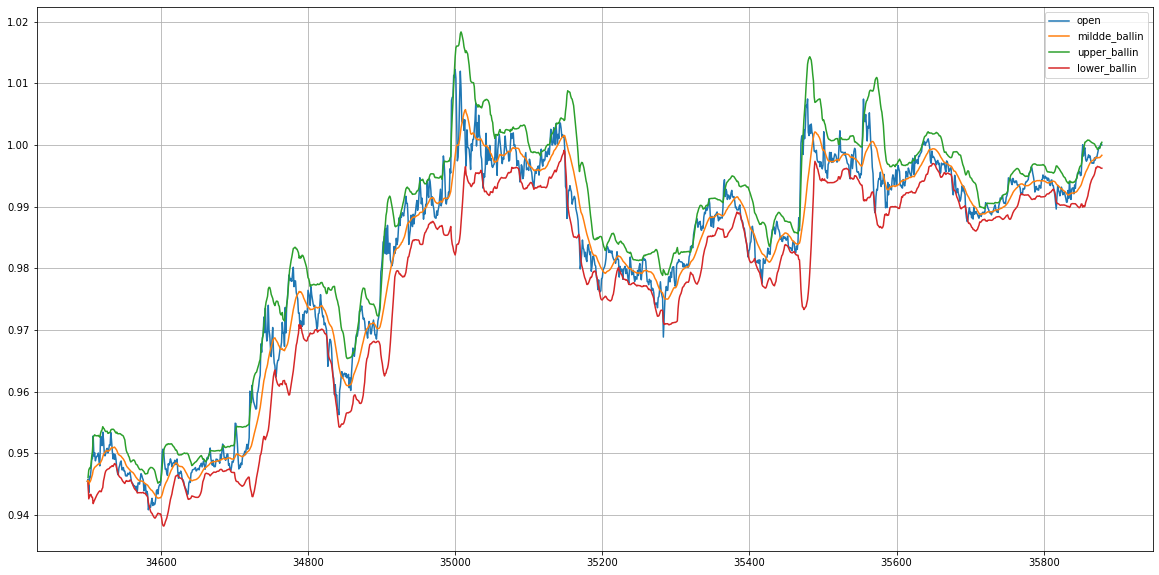

In [17]:
ax1 = temp_df[['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')
plt.show()

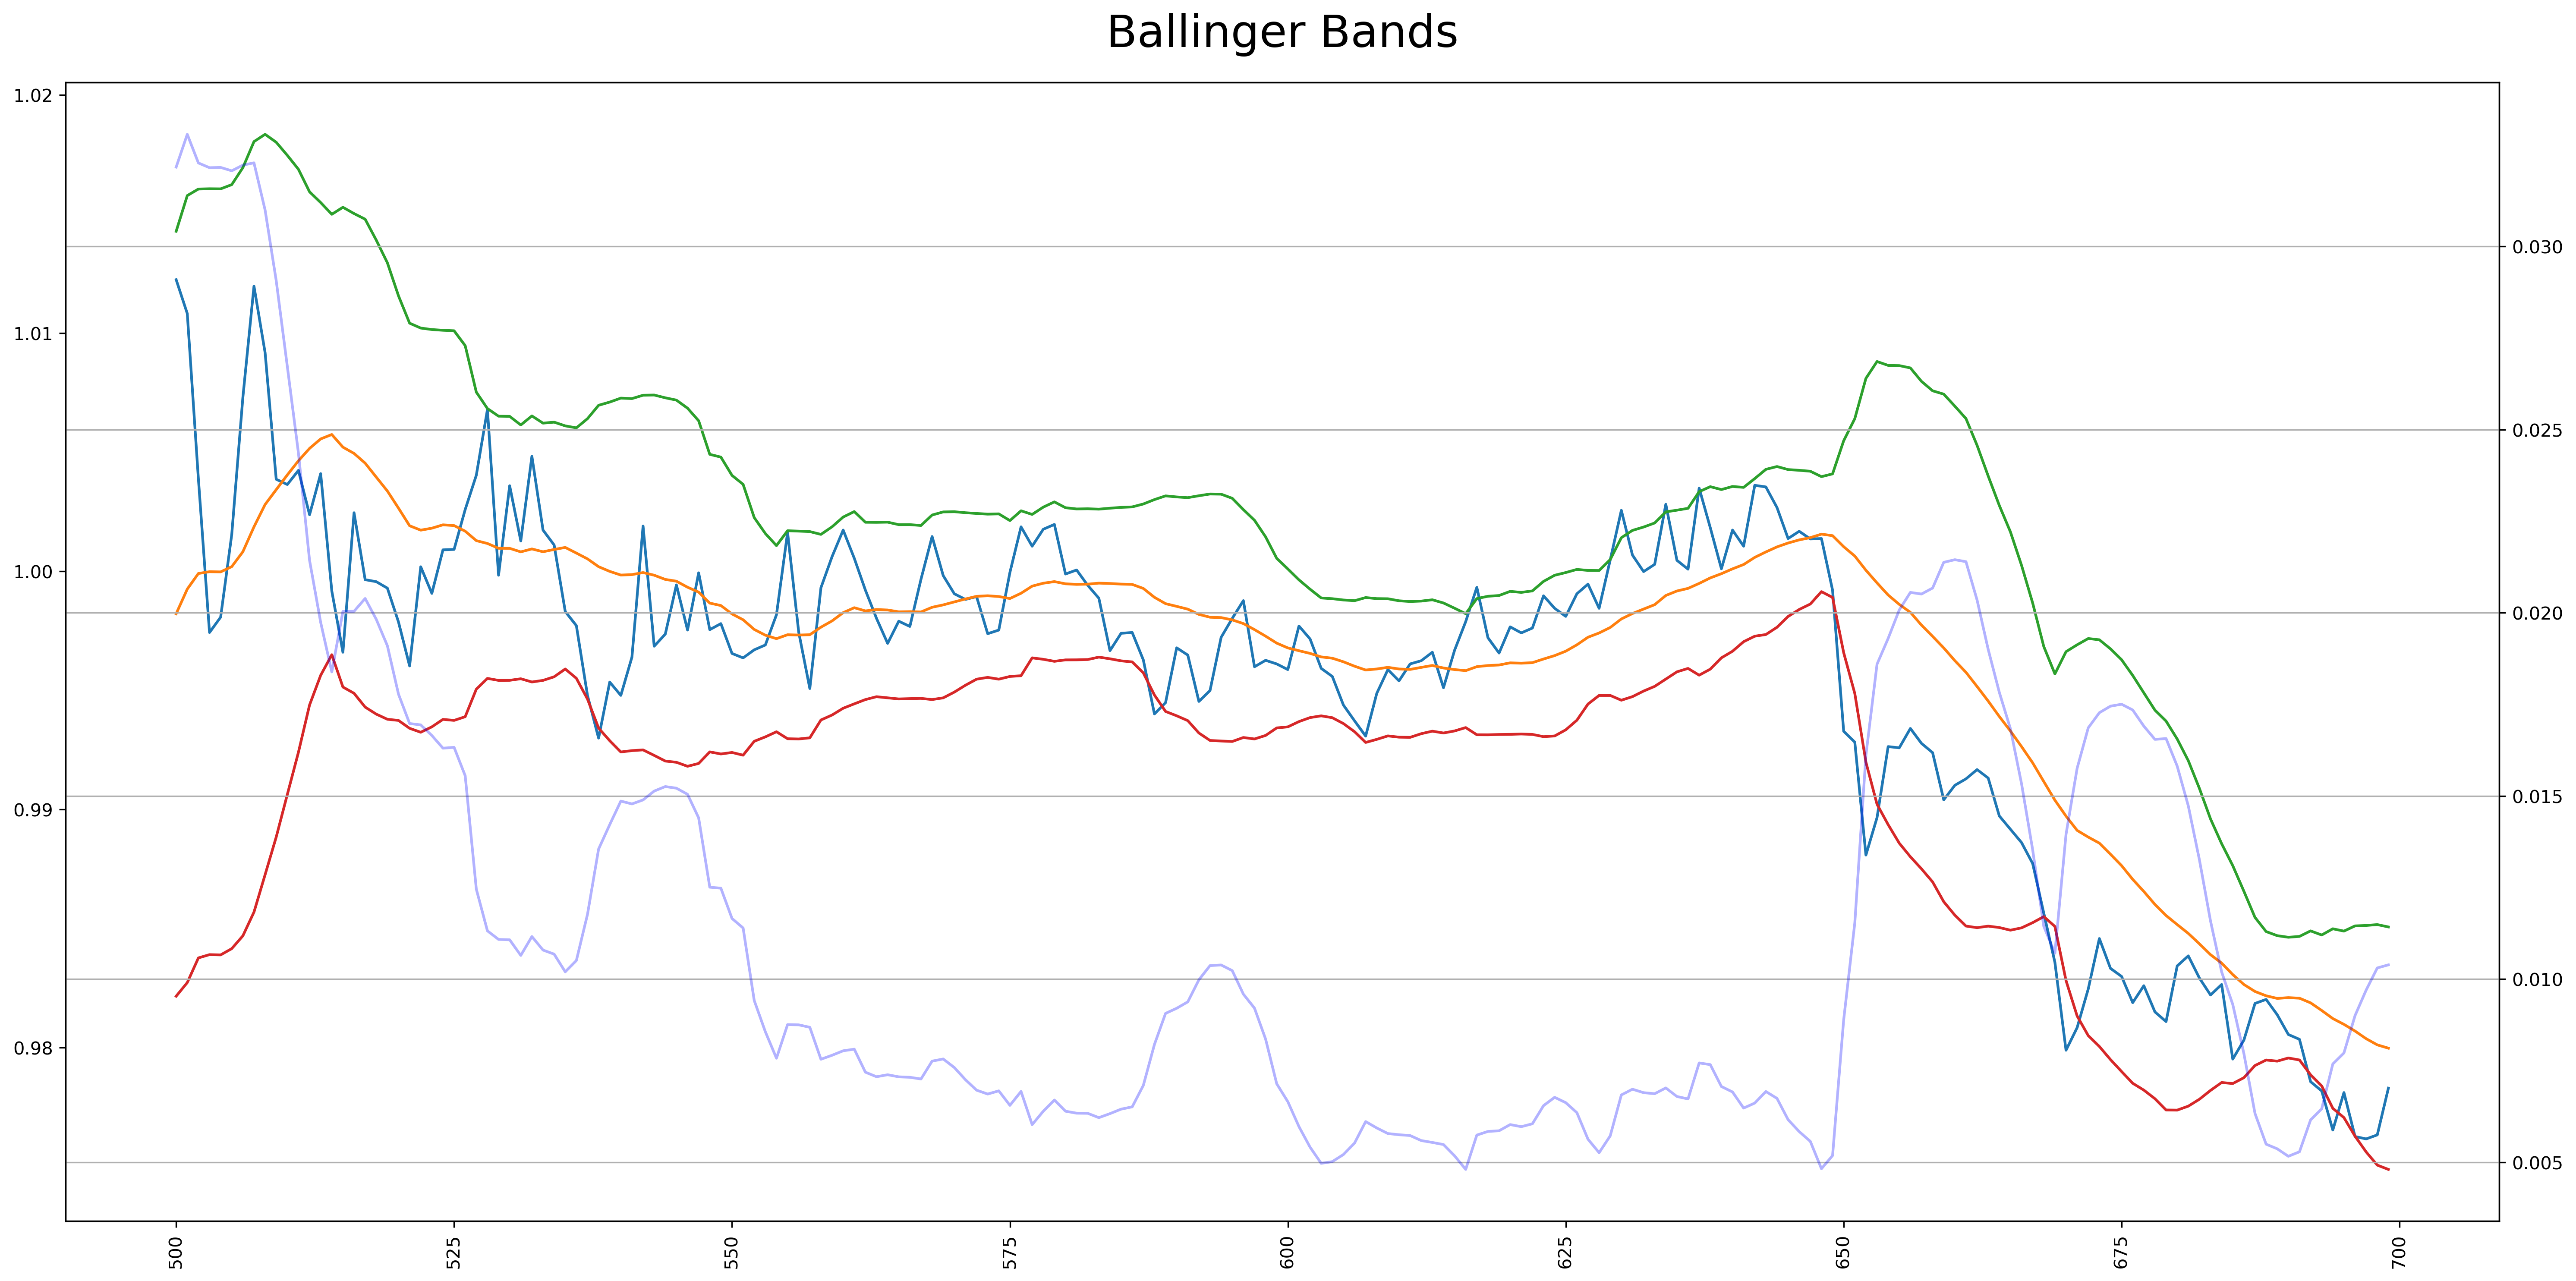

In [35]:
w = 20
h = 10

start_p = 500
end_p = 700

# fig = plt.figure(dpi=300)
fig, ax1 = plt.subplots(figsize=(w, h), dpi=300)

plt.title('Ballinger Bands',fontsize = 25,pad=20)
# ax = temp_df[1:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')

ax1.plot(temp_df[start_p:end_p][['time']], temp_df[start_p:end_p][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']])
# plt.legend(loc=0)

plt.grid()
plt.xticks(rotation=90)

# ax.axes.xaxis.set_ticks([])

ax2 = ax1.twinx()
ax2.plot(temp_df[start_p:end_p][['time']],temp_df[start_p:end_p][['ballin_width']], 'b', alpha=0.3)
# ax2 = temp_df[1:][['ballin_width']].plot(kind='bar',ax=ax1, alpha=0.2, color='blue')
# ax2.axes.xaxis.set_ticks([])

# ax2.axhline(y=6,linewidth=1, color='r')
# ax2.axhline(y=7,linewidth=1, color='r')
plt.tight_layout()
plt.savefig('./results/strategy3')
plt.show()

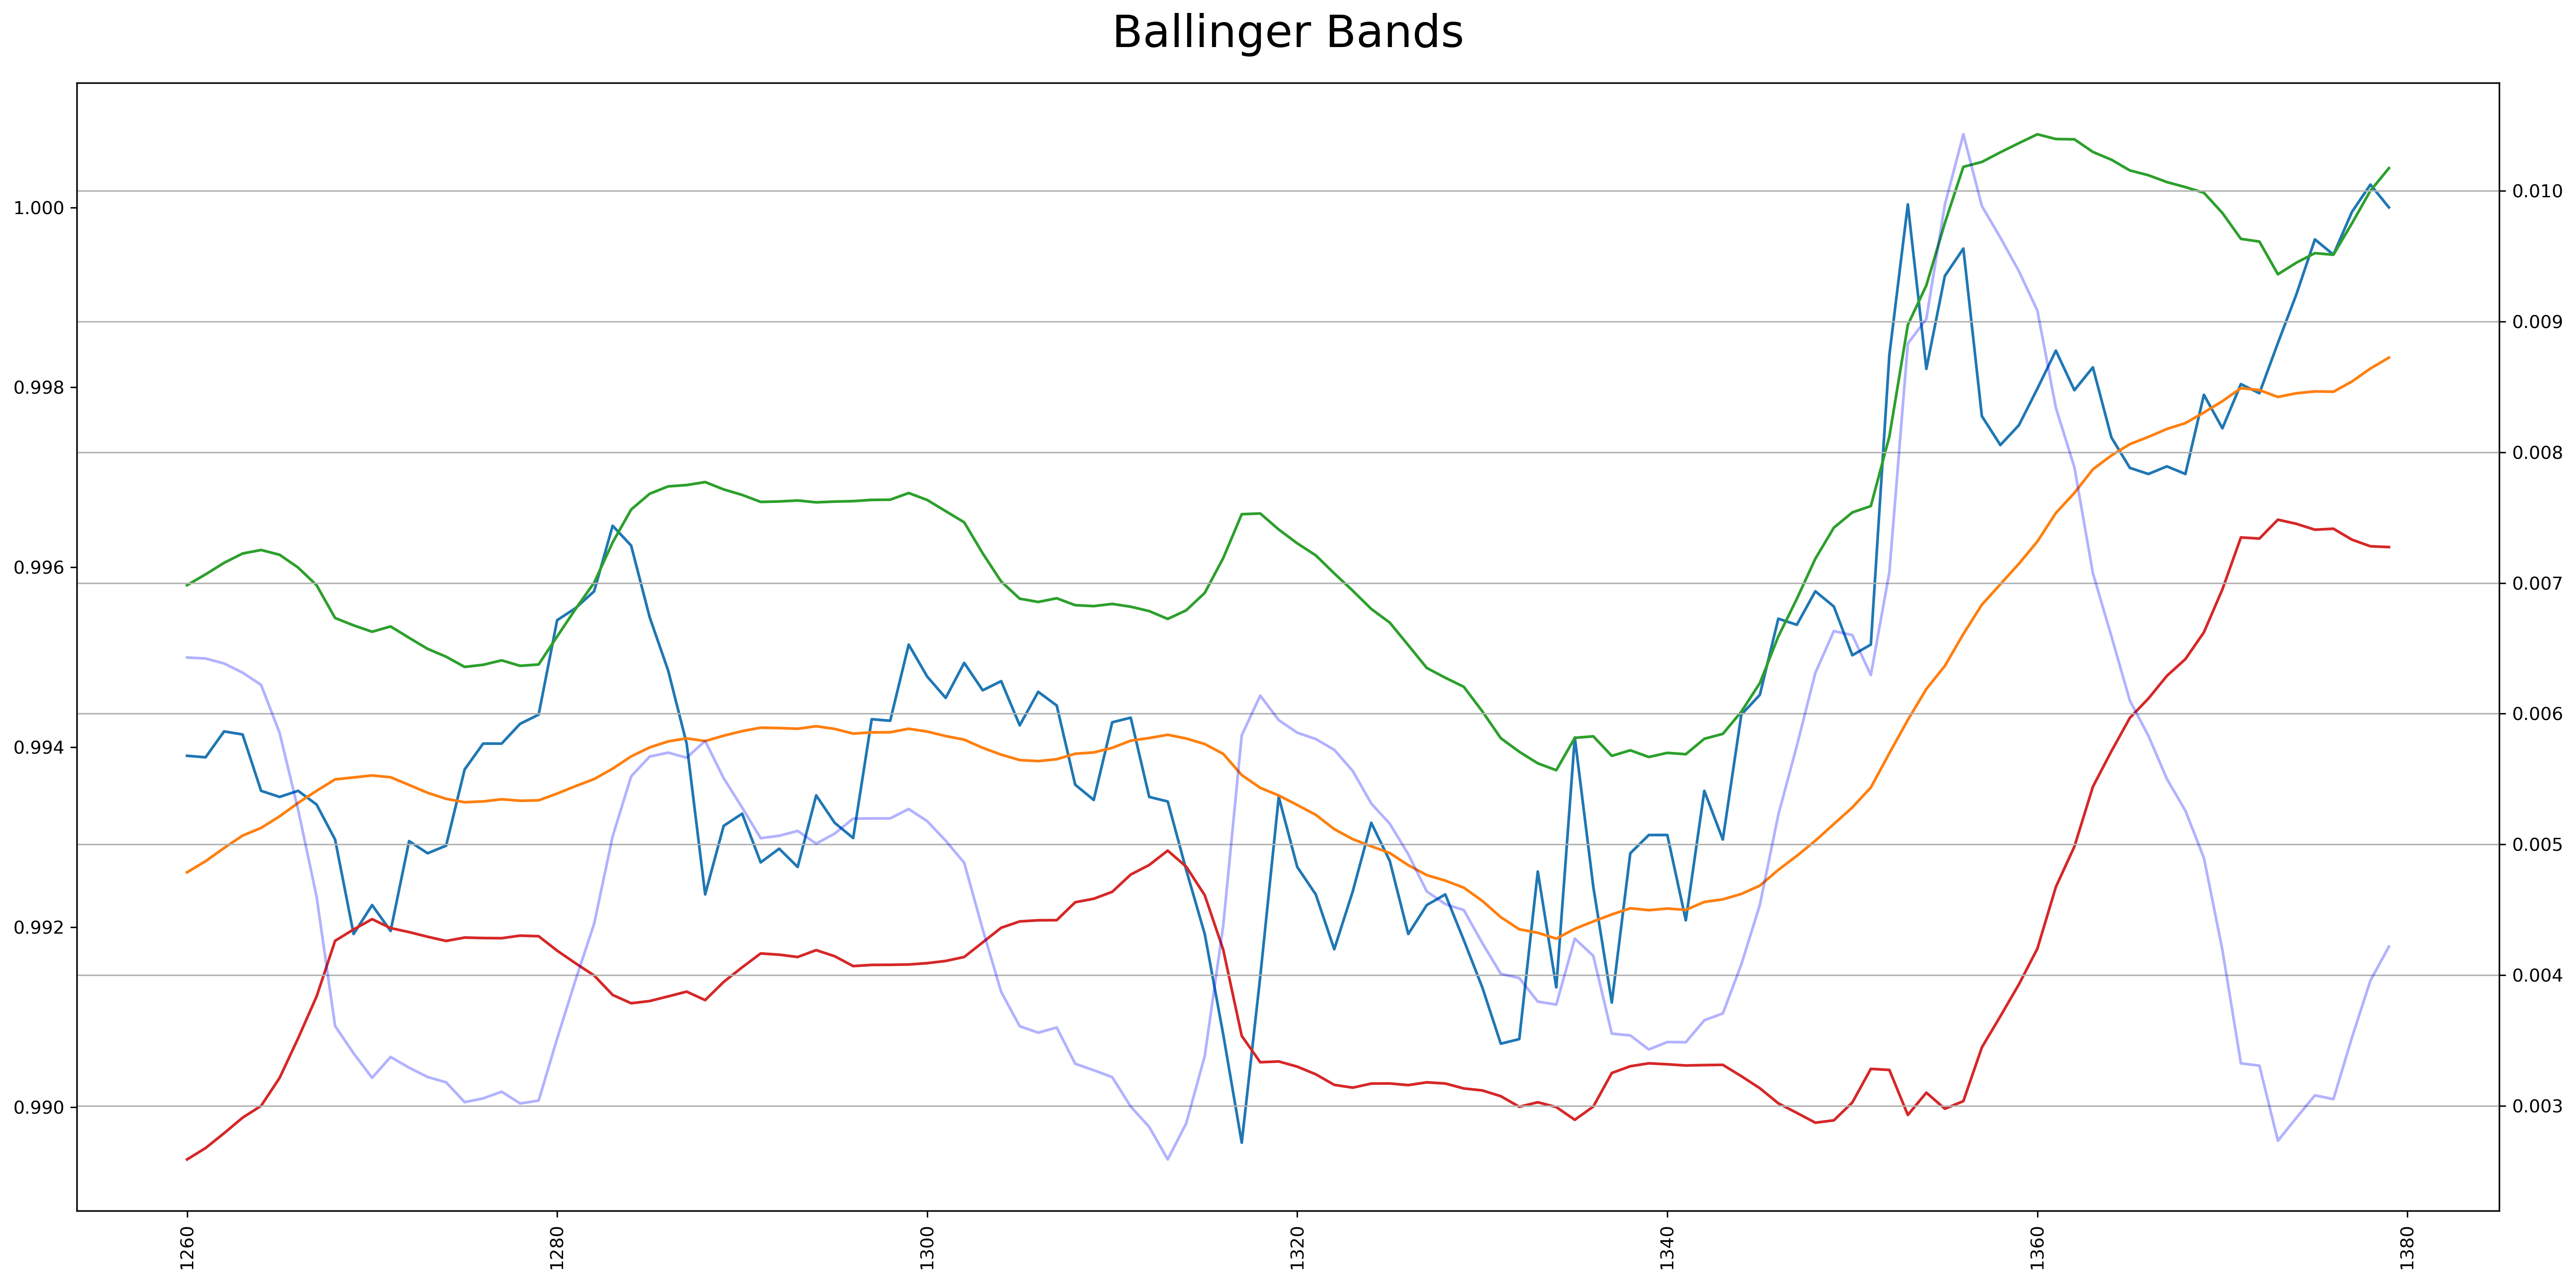

In [20]:
w = 20
h = 10
# fig = plt.figure(dpi=300)
fig, ax1 = plt.subplots(figsize=(w, h), dpi=300)

plt.title('Ballinger Bands',fontsize = 25,pad=20)
# ax = temp_df[1:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')

ax1.plot(temp_df[-120:][['time']], temp_df[-120:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']])
# plt.legend(loc=0)

plt.grid()
plt.xticks(rotation=90)

# ax.axes.xaxis.set_ticks([])

ax2 = ax1.twinx()
ax2.plot(temp_df[-120:][['time']],temp_df[-120:][['ballin_width']], 'b', alpha=0.3)
# ax2 = temp_df[1:][['ballin_width']].plot(kind='bar',ax=ax1, alpha=0.2, color='blue')
# ax2.axes.xaxis.set_ticks([])

# ax2.axhline(y=6,linewidth=1, color='r')
# ax2.axhline(y=7,linewidth=1, color='r')
plt.tight_layout()
plt.show()

In [18]:
result = []

for sample_id in tqdm(TEST_SAMPLE_ID_LIST):

    # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    # 1) diff - ÌïôÏäµÏóê ÏÇ¨Ïö©
    diff_x = get_diff(test_x, sample_id)

    # 2) vwap - Î≥¥Ï°∞ ÏßÄÌëúÎ°ú ÏÇ¨Ïö©
    vwap_series = get_vwap(test_x, sample_id)

    # 3) rsi - Î≥¥Ï°∞ ÏßÄÌëúÎ°ú ÏÇ¨Ïö©
    rsi_series = get_rsi(test_x, sample_id)



    # 2. ARIMA
    # 1) Î™®Îç∏ Ï†ïÏùò
    ARIMA_MODEL = {}
    ARIMA_MODEL_FIT = {}

    # 2) AR Î™®Îç∏ Ï†ÅÏö©
    try:
      ARIMA_MODEL = ARIMA(diff_x, order = (4,0,1))
      ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 3) ÏàòÎ†¥ÌïòÏßÄ ÏïäÏùÑ Í≤ΩÏö∞ p d q Î•º 1, 1, 0ÏúºÎ°ú ÏÇ¨Ïö©
    except:
      ARIMA_MODEL = ARIMA(diff_x, order = (1,1,0))
      ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 4) ARIMA ÏòàÏ∏°
    ARIMA_FORECAST  = ARIMA_MODEL_FIT.predict(1,120, typ='levels')



    # 3. Îç∞Ïù¥Ï≤ò Ï≤òÎ¶¨
    # 1) ÏµúÎåÄ Î∂ÄÎ∂ÑÏù∏ Ïù∏Îç±Ïä§Î•º Ï∞æÎäîÎç∞ Ìï¥Îãπ ÏãúÏ†êÏóê Îß§ÎèÑÎ•º ÏßÑÌñâÌï©ÎãàÎã§.
    sell_time = np.argmax(ARIMA_FORECAST)

    # 2) ÏµúÎåÄÍ∞íÏùÑ Ï∞æÏäµÎãàÎã§.
    max_val = np.max(ARIMA_FORECAST)
    
    # 3) vwapÏùò ÎßàÏßÄÎßâ Í∞íÏùÑ Í∞ÄÏ†∏ÏòµÎãàÎã§.
    vwap_last_val = vwap_series[1379]
    rsi_last_val = rsi_series[1379]



    # 4. Ìà¨Ïûê Ï†ÑÎûµ
    buy_quantity = 0

    # 1) ÏµúÎåÄÍ∞íÏù¥ 0 Î≥¥Îã§ ÌÅ¨Î©¥ Í∞ÄÍ≤©Ïù¥ vwap Î≥¥Îã§ ÌÅ¨Îã§Îäî ÏùòÎØ∏Î°ú, Ìà¨ÏûêÌï©ÎãàÎã§.
    if  max_val > 0:
        buy_quantity = 1
'''
  #  ------------------------------------------------------------------------------------------
  # Îß§ÎèÑ Ï°∞Í±¥Ïóê Î≥ºÎ¶∞Ï†Ä Ï†úÏïΩ Ï∂îÍ∞ÄÌï† Í≤ÉÏûÑ -->ÎØºÍµê 
  # ÏòàÎ•ºÎì§Î©¥ np.argmax(ARIMA_FORECAST) Í∞Ä Î≥ºÎ∞¥ ÏÉÅÎã®Ïù¥ÌÉàÏãú Îß§ÎèÑ 
  #  ---------
'''

    # 2) ÎßåÏïΩ vwap ÎßàÏßÄÎßâ Í∞íÏù¥, 1Î≥¥Îã§ ÌÅ¨Î©¥ Í∞ÄÍ≤©Ïù¥ 1Î≥¥Îã§ ÏûëÎã§Îäî ÏùòÎØ∏Î°ú ÌïòÌñ•ÏÑ∏Ïù¥Í∏∞ ÎïåÎ¨∏Ïóê Ìà¨ÏûêÌïòÏßÄ ÏïäÏäµÎãàÎã§.
    if vwap_last_val > 1 and sell_time < 50:
        buy_quantity = 0

'''
 #  ------------------------------------------------------------------------------------------
    # 3) ÎßåÏïΩ rsiÏùò Í∞íÏù¥ 65 Î≥¥Îã§ ÌÅ¨Î©¥, Ï¥àÍ≥ºÎß§Ïàò ÏÉÅÌÉúÎ°ú ÌåêÎã®ÌïòÏó¨ Ìà¨ÏûêÌïòÏßÄ ÏïäÏäµÎãàÎã§.
# 07.05 22:29 ris Í∞íÏù¥ 75 Î≥¥Îã§ ÌÅ¨Î©¥ Ï¥àÍ≥ºÎß§ÏàòÎ°ú ÌåêÎã®ÌïòÎèÑÎ°ù ÏàòÏ†ï (Î≥ÄÎèôÏÑ± ÏµúÎåÄÌïú Ìà¨ÏûÖ)
# 07.11 RSI ÏÉÅÎã® ÌÑ∞ÏπòÌõÑ sell time rest Í∏∞Í∞ÑÏù¥ 50Î∂Ñ Ïù∏Îç∞ Ïù¥Í≤å Ï†ÅÏ†àÌïú Í≤ÉÏùºÏßÄ ÏùòÎ¨∏
'''
    # 3) ÎßåÏïΩ rsiÏùò Í∞íÏù¥ 65 Î≥¥Îã§ ÌÅ¨Î©¥, Ï¥àÍ≥ºÎß§Ïàò ÏÉÅÌÉúÎ°ú ÌåêÎã®ÌïòÏó¨ Ìà¨ÏûêÌïòÏßÄ ÏïäÏäµÎãàÎã§.
    if rsi_last_val > 75 and sell_time < 50:
        buy_quantity = 0



    # 5. Í≤∞Í≥º
    result_list = [
                   sample_id,
                   buy_quantity,
                   sell_time
                  ]

    result.append(result_list)
    

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: 

# 8. Ï†úÏ∂ú üéâ

In [19]:
# 1. ÌïôÏäµ Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏúºÎ°ú ÎßåÎì≠ÎãàÎã§.

submit_columns = [
                  "sample_id", 
                  "buy_quantity", 
                  "sell_time"
                  ]


submit = pd.DataFrame(data=result, columns=submit_columns)


In [76]:
for x in grouped_data:
    # get one sample_id in sample list
    grouped_df.get_group(temp_sample_id)
    break

NameError: name 'grouped_df' is not defined

In [20]:
# 2. Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÌôïÏù∏

submit.head(10)


sample_id  buy_quantity  sell_time
0       7661             0         47
1       7662             1         62
2       7663             0         11
3       7664             0         48
4       7665             1         46
5       7666             1         70
6       7667             1        119
7       7668             1         82
8       7669             1        109
9       7670             1         66

In [96]:
temp_data.columns

Index(['sample_id', 'time', 'coin_index', 'open', 'high', 'low', 'close',
       'volume', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av',
       'volume_tb_base_av', 'volume_price', 'volume_price_sum', 'volume_sum',
       'vwap', 'diff', 'U', 'D', 'AU', 'AD', 'rsi', 'mildde_ballin',
       'upper_ballin', 'lower_ballin'],
      dtype='object')

In [21]:
# 3. Ìà¨Ïûê Í∞úÏàò ÌôïÏù∏

submit[submit["buy_quantity"] == 1].shape[0]


420

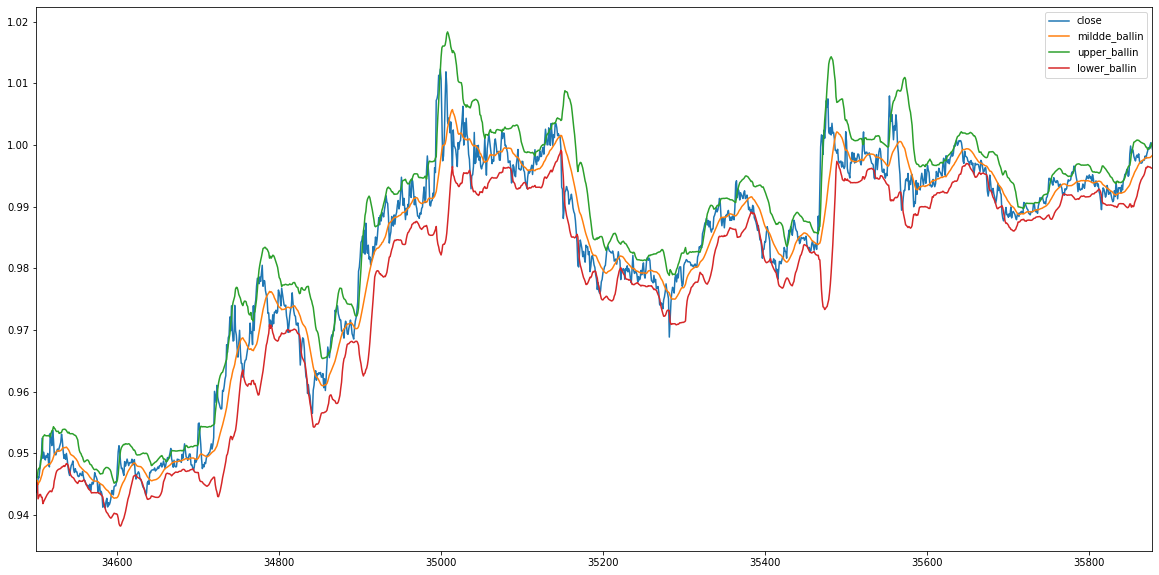

In [118]:
# f = plt.figure(figsize=(20, 10))
f = temp_data[temp_data['sample_id'] == 7954][['close', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot()
plt.show()

In [22]:
# 4. sell_time 50ÎØ∏ÎßåÏóêÏÑú Íµ¨Îß§ÌïòÎäî Í∞úÏàò ÌôïÏù∏
cond1 = (submit["buy_quantity"] == 1)
cond2 = (submit["sell_time"] < 50)

submit[cond1 & cond2].shape[0]


84

In [23]:
# 5. Ï†úÏ∂ú

In [23]:
temp_data = test_x["open"]

In [24]:
# ÌååÏùºÏùò Ïù¥Î¶ÑÏùÑ ÏßÄÏ†ïÌï¥Ï§çÎãàÎã§.
FILE_NAME = "/0603_ARIMA_DIFF_VWAP_RSI_65_UNDER_50_SUBMIT.csv"


In [40]:
temp_data

0          0.941549
1          0.941586
2          0.941270
3          0.940971
4          0.940077
             ...   
1048795    1.005905
1048796    1.006243
1048797    1.004608
1048798    1.002865
1048799    1.000000
Name: open, Length: 1048800, dtype: float64

In [52]:
grouped_data = temp_data.groupby(['sample_id'])

In [25]:
# Ï†úÏ∂úÍ≤ΩÎ°úÏóê ÌååÏùºÏùÑ ÏÉùÏÑ±Ìï¥Ï§çÎãàÎã§.
RESULT_PATH = SUBMIT_PATH + FILE_NAME

submit.to_csv(RESULT_PATH, index=False)


(7929,       sample_id  time  coin_index      open      high       low     close  \
0          7929     0           1  0.941549  0.941773  0.940431  0.941176   
1          7929     1           1  0.941586  0.941736  0.940282  0.940897   
2          7929     2           1  0.941270  0.941586  0.938940  0.940934   
3          7929     3           1  0.940971  0.941363  0.939052  0.940319   
4          7929     4           1  0.940077  0.940561  0.939760  0.939909   
...         ...   ...         ...       ...       ...       ...       ...   
1375       7929  1375           1  1.001305  1.001789  0.999534  0.999758   
1376       7929  1376           1  0.999478  0.999478  0.998136  0.998714   
1377       7929  1377           1  0.998900  0.999161  0.998136  0.999105   
1378       7929  1378           1  0.999124  1.000261  0.999124  1.000112   
1379       7929  1379           1  1.000000  1.000298  0.999236  0.999404   

        volume    quote_av    trades  ...  volume_price  volume_pric

TypeError: tuple indices must be integers or slices, not str

# 9. ÏïàÏ†ïÏ†Å Î™®Îç∏Ïù∏ÏßÄ Ïñ¥ÎñªÍ≤å ÌôïÏù∏? ü§î
ÏãúÏ¶å 1ÏùÑ Í≤ΩÌóòÌïòÍ≥†, ÏµúÎåÄÌïú ÏïàÏ†ïÏ†ÅÏù∏ Î™®Îç∏ÏùÑ ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥ ÎÖ∏Î†•ÌñàÏäµÎãàÎã§. 

Îã§Îßå, ÎÇ¥Í∞Ä ÏïàÏ†ïÏ†ÅÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌï¥ÎèÑ, Í∞ùÍ¥ÄÏ†ÅÏù∏ ÏßÄÌëúÍ∞Ä ÏóÜÎã§Î≥¥Îãà ÏñºÎßàÎÇò Í∑†ÌòïÏû°ÌòÄÏûàÎäîÏßÄ ÌôïÏù∏ÌïòÍ∏∞Í∞Ä Ïñ¥Î†§Ïõ†ÏäµÎãàÎã§.

Ïù¥Î•º ÏúÑÌï¥ public scoreÎ•º Îã§ÏùåÍ≥º Í∞ôÏù¥ ÌôúÏö©ÌñàÏäµÎãàÎã§.

<br>

ÏòàÎ•º Îì§Ïñ¥, 
- openÏóê vwapÏùÑ ÏÑûÏñ¥ Ìà¨ÏûêÍ∞úÏàòÍ∞Ä Ï§ÑÏóàÏùåÏóêÎèÑ Ï†êÏàòÍ∞Ä Ïò¨ÎùºÍ∞ÄÎäî ÌòÑÏÉÅ
- vwap, rsiÎì± Î≥¥Ï°∞ÏßÄÌëúÎ•º ÌÜµÌï¥ sell_time 10, 20.. 50 ÎØ∏ÎßåÏùÄ Ìà¨ÏûêÌïòÏßÄ ÏïäÍ∏∞Î°ú Í≤∞Ï†ïÌñàÏùåÏóêÎèÑ Ï†êÏ†ê Ï†êÏàòÍ∞Ä Ïò¨ÎùºÍ∞ÄÎäî ÌòÑÏÉÅ
- rsi Ï¥àÍ≥ºÎß§ÏàòÎ°ú ÏÉÅÌÉúÎ•º 70 Ï¥àÍ≥ºÍ∞Ä ÏïÑÎãå, 65 Ï¥àÍ≥ºÎ°ú, Îçî ÏïàÏ†ïÏ†ÅÏúºÎ°ú Í≤∞Ï†ïÌï¥ÎèÑ Ï†êÏàòÍ∞Ä ÏÉÅÏäπÌïòÎäî ÌòÑÏÉÅ
<br>

Ïù¥Î†áÍ≤å, Ï†úÏïΩÏÇ¨Ìï≠ÏùÑ ÌÜµÌï¥ Î≥¥ÏàòÏ†ÅÏúºÎ°ú Ìà¨ÏûêÌñàÏùåÏóêÎèÑ Î∂àÍµ¨ÌïòÍ≥†, Ï†êÏàòÍ∞Ä Ïò¨ÎùºÍ∞ÄÎäî Í≤ΩÏö∞Ïóê ÏßëÏ§ëÌïòÏó¨, Ìï¥Îãπ ÌîºÏ≥êÍ∞Ä ÏïàÏ†ïÏ†ÅÏúºÎ°ú ÏûëÏö©Ìï®ÏùÑ ÌåêÎã®ÌñàÏäµÎãàÎã§.


In [31]:
temp_data[:20]

0     0.941549
1     0.941586
2     0.941270
3     0.940971
4     0.940077
5     0.940189
6     0.941400
7     0.941885
8     0.941810
9     0.941885
10    0.939779
11    0.941307
12    0.940487
13    0.941586
14    0.941754
15    0.939089
16    0.939238
17    0.939704
18    0.940151
19    0.939723
Name: open, dtype: float64

In [36]:
temp_data.rolling(20, min_periods=1).mean()[:20]

0     0.941549
1     0.941568
2     0.941468
3     0.941344
4     0.941091
5     0.940940
6     0.941006
7     0.941116
8     0.941193
9     0.941262
10    0.941127
11    0.941142
12    0.941092
13    0.941127
14    0.941169
15    0.941039
16    0.940933
17    0.940865
18    0.940827
19    0.940772
Name: open, dtype: float64

In [30]:
temp_data[:20].mean()

0.9407719761133194

In [ ]:
def BBands(df_close, w=20, k=2):
    """
        w: Ïù¥ÎèôÌèâÍ∑†ÏÑ† Í∏∞Í∞Ñ Í∞í (20)
        k: ÏäπÏàò (2)
    """
    # Í≥†Í∞Ä, Ï†ÄÍ∞Ä, Ï¢ÖÍ∞ÄÏùò ÌèâÍ∑†ÏùÑ Ïù¥Ïö©ÌïòÎäî Í≤ΩÏö∞ Ï†ïÏàòÎ°ú Î≥ÄÌôòÏù¥ ÌïÑÏöî
    df_close = df_close.astype(int)
    # ÌëúÏ§ÄÌé∏Ï∞®
    std = df_close[:w].std()[0]
    # mean() Ìï®ÏàòÎäî 'ÌèâÍ∑†ÏùÑ Íµ¨ÌïòÍ∏∞ ÏúÑÌïú' numpy Ìå®ÌÇ§ÏßÄÏóê Ìè¨Ìï®ÎêòÏñ¥ ÏûàÎäî ÎÇ¥Ïû• Ìï®ÏàòÏûÖÎãàÎã§.
    # 20Ïùº Ïù¥ÌèâÏÑ†Ïù¥Ïûê Î≥ºÎ¶∞Ï†ÄÎ∞¥Îìú Ï§ëÏïôÏÑ†
    mbb = df_close[:w].mean()[0]
    # Ï¢ÖÍ∞Ä
    close = df_close[0][0]

    '''
        std (ÌëúÏ§ÄÌé∏Ï∞® Í∞í)Í≥º mbb(Ï§ëÏïôÏÑ†)ÏùÑ Ïù¥Ïö©ÌïòÏó¨ Î≥ºÎ¶∞Ï†ÄÎ∞¥Îìú
        1. ubb (ÏÉÅÌïúÏÑ†)
        2. lbb (ÌïòÌïúÏÑ†)
        3. perb (%b: Î≥ºÎ¶∞Ï†ÄÎ∞¥ÎìúÏóêÏÑúÏùò Ï¢ÖÍ∞Ä ÏúÑÏπò)
        4. bw (Î∞¥ÎìúÌè≠)
        4Í∞úÏùò Í∞íÏùÑ Íµ¨ÌïòÎäî ÏàòÏãùÏùÑ 01)Î≥ºÎ¶∞Ï†ÄÎ∞¥Îìú Í∞úÎÖêÏóê ÏïàÎÇ¥ÎêòÏñ¥ ÏûàÎäî [Î≥ºÎ¶∞Ï†Ä Î∞¥Îìú Í≥ÑÏÇ∞Î∞©Î≤ï]ÏùÑ Ï∞∏Í≥†ÌïòÏó¨ Íµ¨ÌòÑÌï¥Ï£ºÏÑ∏Ïöî.
        Î≥ÄÏàò Ïù¥Î¶ÑÏùÄ ubb, lbb, perb, bwÎ°ú ÌÜµÏùºÌïòÏó¨ Ï£ºÏãúÍ∏∞ Î∞îÎûçÎãàÎã§.
    '''

    # Î≥ºÎ¶∞Ï†ÄÎ∞¥Îìú ÏÉÅÌïúÏÑ†Í≥º ÌïòÌïúÏÑ† ÏàòÏπò Íµ¨ÌïòÎäî Ïãù
    ### blank ###########################
    # ubb =
    # lbb =
    #####################################

    if ubb > lbb:
        ### blank ###########################
        # perb =
        # bw =
        #####################################
        return mbb, ubb, lbb, perb, bw
    else:
        return False

# 10. Ïó¨Îü¨ ÏïÑÏù¥ÎîîÏñ¥ ü•¥
65Î≤àÏù¥ÎùºÎäî Ï°∞Í∏à ÎßéÏùÄ Ï†úÏ∂úÏùÑ ÌÜµÌï¥ Ïó¨Îü¨ ÏãúÎèÑÎ•º ÏßÑÌñâÌñàÏäµÎãàÎã§. Ï†ÄÏùò Í∞úÏù∏Ï†ÅÏù∏ Í≤∞Í≥ºÎäî Ï¢ãÏßÄ ÏïäÏïòÏäµÎãàÎã§Îßå, ÌòπÏãúÎÇò Ïù¥ÌõÑ ÎåÄÌöåÏóêÏÑú Îã§Î•∏ Î∂ÑÎì§ÏóêÍ≤å Ï°∞Í∏àÏù¥ÎùºÎèÑ ÎèÑÏõÄÏù¥ Îê† Ïàò ÏûàÏùÑÍπå Ìï¥ÏÑú ÎÇ®Í∏∞Í≤å ÎêòÏóàÏäµÎãàÎã§.

<br>

### 1) RANDOM BOX Î∂ÑÎ•ò Î™®Îç∏
ÏãúÍ≥ÑÏó¥ ÎåÄÌöåÏù¥ÏßÄÎßå, classificationÏúºÎ°ú ÏÉùÍ∞ÅÌï¥Î≥¥ÏïòÏäµÎãàÎã§.

Í≤∞Íµ≠Ïóê Ï†úÍ∞Ä ÏÑ†ÌÉùÌïòÎäîÍ≤ÉÏùÄ 120Í∞úÏ§ë 1Í∞úÏù¥Í∏∞ ÎïåÎ¨∏Ïóê 120Í∞úÏùò ÏÉÅÏûê Ï§ë 1Í∞úÎ•º ÏÑ†ÌÉùÌñàÏùÑÎïå Í∑∏ Í∞íÏù¥ 1Î≥¥Îã§ ÌÅ¥ ÌôïÎ•†ÏùÑ Ï†úÍ∞Ä ÏñªÏùÑ Ïàò ÏûàÎäî Í∏∞ÎåÄÍ∞íÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌñàÏäµÎãàÎã§. 

Í∞úÏù∏Ï†ÅÏúºÎ°ú Í∞ÄÏû• Ï∞ΩÏùòÏ†ÅÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌñàÏßÄÎßå, Ïûò ÏïàÎêòÏóàÏäµÎãàÎã§. Îçî ÏßÄÎãàÏñ¥Ïä§Ïùò ÏΩ©ÌîàÌå®Ïä§Ïóê ÏòÅÍ∞êÏùÑ Î∞õÏïòÏäµÎãàÎã§.


<br>

### 2) ÌòºÌï© Îç∞Ïù¥ÌÑ∞
openÏóê vwapÏùÑ ÏÑûÏùÄÍ≤ÉÏóê ÎçîÌïòÏó¨, RSI, Ïù¥ÎèôÌèâÍ∑†ÏÑ†Îì±ÏùÑ Î™®Îëê ÏÑûÏñ¥ Î≥¥ÏïòÏäµÎãàÎã§. ÏÉùÍ∞ÅÎ≥¥Îã§ Ï†êÏàòÍ∞Ä Ï†ïÎßê Ï¢ãÏïòÏßÄÎßå, vwap ÌïúÍ∞úÎ•º ÏÑûÏùÄÍ≤ÉÎ≥¥Îã§Îäî ÏïÑÏâΩÎã§Í≥† ÏÉùÍ∞ÅÌïòÏó¨ ÏÇ¨Ïö©ÌïòÏßÄÎäî ÏïäÏïòÏäµÎãàÎã§.

<br>



# 11. Îã§Î•∏ Î™®Îç∏ ÏÇ¨Ïö©Ïó¨Î∂Ä üòÅ
ARIMA Ïù¥Ïô∏ÏóêÎèÑ prophet, neural prophet, LSTMÎì± Îã§ÏñëÌïú Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï¥Î≥¥ÏïòÏäµÎãàÎã§. 

Îã§Îßå, Îçî Ï¢ãÏùÄ Í≤∞Í≥ºÎ•º Ï£ºÏßÄ ÏïäÏïòÎã§Í≥† ÌåêÎã®ÌñàÏäµÎãàÎã§.

ÎòêÌïú, ÏúÑ Î™®Îç∏Îì§Ïùò Í≤∞Í≥ºÎ•º baggingÌïòÎäî Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©Ìï¥Î≥¥ÏïòÏßÄÎßå, ARIMA Îã® ÌïòÎÇòÎßåÏùÑ ÏÇ¨Ïö©ÌñàÏùÑÎïåÎ≥¥Îã§ ÏòàÏ∏° ÏÑ±Îä•Ïù¥ ÎÇÆÏïÑÏßÑÎã§Í≥† ÌåêÎã®ÌïòÏó¨ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÍ≤å ÎêòÏóàÏäµÎãàÎã§.



# 7. Î™®Îç∏ ÌïôÏäµ ü§ë